In [5]:
import os, boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError

In [ ]:
def read_s3_to_dataframe(bucket_name: str, s3_file_path: str) -> pd.DataFrame:
    try:
        s3_client = boto3.client(
            's3',
            region_name= os.getenv("REGION"),
            aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID"),
            aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY"),
        )
        
        obj = s3_client.get_object(Bucket=bucket_name, Key=s3_file_path)
        df = pd.read_csv(obj['Body'], header = 0)
        
        return df
    
    except ClientError as error:
        error_code = error.response.get('Error', {}).get('Code', 'Unknown')
        error_message = error.response.get('Error', {}).get('Message', str(error))
        print(f"AWS Error ({error_code}): {error_message}")
        raise
    except Exception as error:
        print(f"Unexpected error: {str(error)}")
        raise
    
animal_df = read_s3_to_dataframe(
    bucket_name="animal-center",
    s3_file_path="curated/austin-animal-center-curated.csv"
)

# **Austin Animal Center**

- Monthly animal intake trends
- Distribution of intake types and conditions.
- Breakdown of intake data by breed or location.


In [9]:
animal_df['datetime'] = pd.to_datetime(animal_df['datetime'])

### Distribution of intake types and conditions.


In [10]:
animal_type_df = animal_df[["animal_id", "intake_type", "intake_condition"]] \
.groupby(["intake_type", "intake_condition"]) \
.count() \
.rename(columns = {"animal_id": "Number of animals"})

In [11]:
intake_type = []
intake_condition = []

for animal_type in list(animal_type_df.index):
    intake_type.append(animal_type[0])
    intake_condition.append(animal_type[1])

animal_type_condition_dist_df = pd.DataFrame(
    {
        "intake_type": intake_type,
        "intake_condition": intake_condition,
        "number_animal": list(animal_type_df[['Number of animals']].values.ravel())
    }
)

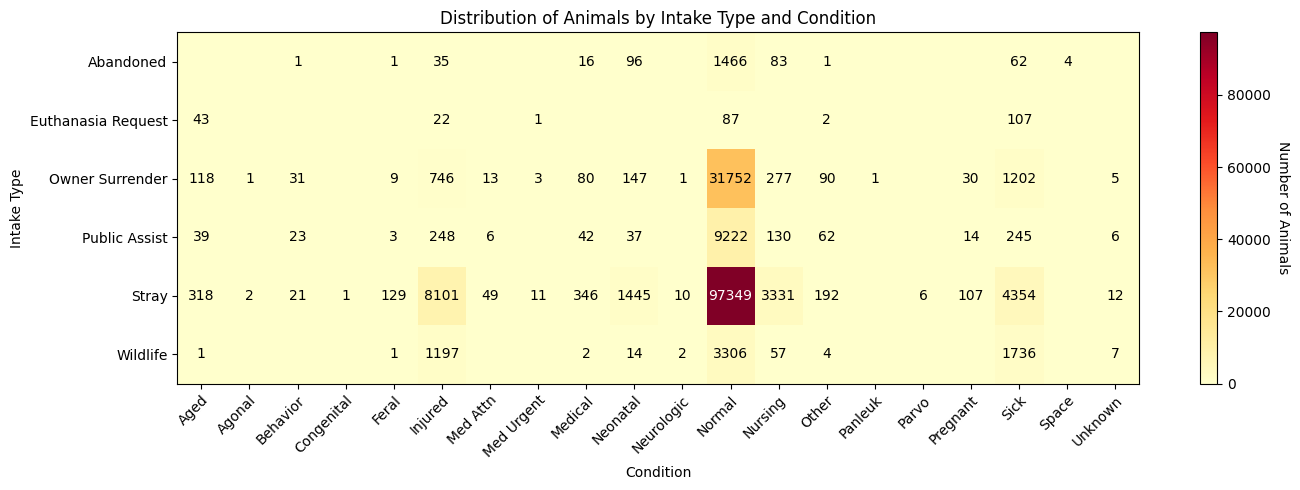

In [12]:
pivot_table = animal_type_condition_dist_df.pivot(
    index='intake_type', 
    columns='intake_condition', 
    values='number_animal'
).fillna(0)

fig, ax = plt.subplots(figsize=(14, 5))

im = ax.imshow(pivot_table, aspect='auto', cmap='YlOrRd')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of Animals', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns)
ax.set_yticklabels(pivot_table.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for condition in range(len(pivot_table.index)):
    for intake_type in range(len(pivot_table.columns)):
        value = pivot_table.iloc[condition, intake_type]
        if value > 0:  
            text_color = 'white' if value > pivot_table.values.max() / 2 else 'black'
            ax.text(intake_type, condition, f'{int(value)}', 
                   ha="center", va="center", 
                   color=text_color)

ax.set_title('Distribution of Animals by Intake Type and Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Intake Type')

plt.tight_layout()
plt.show()

### Monthly animal intake trends


In [18]:
animal_df.groupby("datetime")[['name']].count()

,name
datetime,
2013-10-01 07:51:00+00:00,1
2013-10-01 08:33:00+00:00,3
2013-10-01 08:53:00+00:00,1
2013-10-01 09:33:00+00:00,1
2013-10-01 10:37:00+00:00,1
...,...
2024-11-10 13:17:00+00:00,1
2024-11-10 13:44:00+00:00,1
2024-11-10 13:49:00+00:00,1
